In [1]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

## download dataset 
!kaggle datasets download -d becksddf/churn-in-telecoms-dataset

## unzip dataset
!unzip "churn-in-telecoms-dataset.zip" -d "churn_dataset"

     |████████████████████████████████| 61kB 2.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=3ff9b062585883764cee580e4f9e40e48becf84159ebd1674f10b094d5c8e6b6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


Saving kaggle.json to kaggle.json
kaggle.json
  0% 0.00/116k [00:00<?, ?B/s]
100% 116k/116k [00:00<00:00, 39.0MB/s]
Archive:  churn-in-telecoms-dataset.zip
  inflating: churn_dataset/bigml_59c28831336c6604c800002a.csv  


## Import Libraires

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
%matplotlib inline

## EDA

In [87]:
## Reading dataset 
churn_data = pd.read_csv('/content/churn_dataset/bigml_59c28831336c6604c800002a.csv')

## dataset shape 
print(f"{'shape of the dataset'.title()} :- {churn_data.shape}")

## sample data
print(f"{'sample dataset'.title()} :- \n {churn_data.head()}")

## missing values
print(f"\n {'Number of null values in every column'.title()} \n {churn_data.isnull().sum()}")

## duplicate values
print(f"\n {'number of duplicate values'.title()} :- {len(churn_data.loc[churn_data.duplicated()])}")

## target value count 
print(f"\n {'count of each value of target column'.title()} \n {churn_data.churn.value_counts()}")

## information about dataset
print(f"{'dataset info'.title()} \n ")
churn_data.info()

Shape Of The Dataset :- (3333, 21)
Sample Dataset :- 
   state  account length  ...  customer service calls  churn
0    KS             128  ...                       1  False
1    OH             107  ...                       1  False
2    NJ             137  ...                       0  False
3    OH              84  ...                       2  False
4    OK              75  ...                       3  False

[5 rows x 21 columns]

 Number Of Null Values In Every Column 
 state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charg

## DATA Visualization

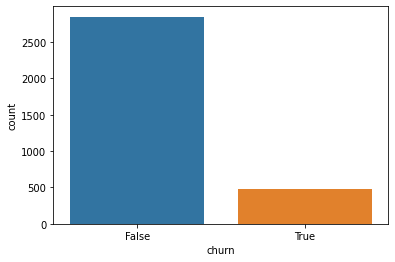

In [10]:
sns.countplot(x ='churn', data = churn_data)
plt.show()

## Preprocessing

In [88]:
def col_unique_values(col_name):
  ## input : category variables
  ## Output : number of unique values in particular category col
  print(f"****************** Col Name : {col_name} ****************")
  print(f"Unique Values :- \n {churn_data[col_name].unique()}")
  print(f"Number of Unique values :- {churn_data[col_name].nunique()}\n\n")


## all columns
total_col_names = churn_data.columns
## find numeric columns (int & float, bool)
num_cols = churn_data._get_numeric_data().columns
## getting category columns 
cat_col_names = list(set(total_col_names) - set(num_cols))


for col_name in cat_col_names:
  ## check unique values of every category column
  col_unique_values(col_name)


## phone number is not important feature so we can remove it
churn_data = churn_data.drop(['phone number'], axis=1)
cat_col_names.remove('phone number')

## Apply label encoding operation on category columns
def label_encoding(col_name):
  le = LabelEncoder()
  churn_data[col_name] = le.fit_transform(churn_data[col_name])


for col_name in cat_col_names:
  label_encoding(col_name)

## sample dataset after label encoding
churn_data.head()

****************** Col Name : state ****************
Unique Values :- 
 ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
Number of Unique values :- 51


****************** Col Name : voice mail plan ****************
Unique Values :- 
 ['yes' 'no']
Number of Unique values :- 2


****************** Col Name : phone number ****************
Unique Values :- 
 ['382-4657' '371-7191' '358-1921' ... '328-8230' '364-6381' '400-4344']
Number of Unique values :- 3333


****************** Col Name : international plan ****************
Unique Values :- 
 ['no' 'yes']
Number of Unique values :- 2




,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [89]:
## separate dependent and independent variables 
X = churn_data.drop(['churn'], axis=1)
y = churn_data['churn']

column_names = list(X.columns)

## create pipeline to apply feature scaling
pipeline = Pipeline([
                     ('std_scaler', StandardScaler())
])

## apply feature scaling on independent values (X)
X = pd.DataFrame(data=pipeline.fit_transform(X), columns=column_names)
X.head()

## label encoding on target variables
le = LabelEncoder()
y = le.fit_transform(y)

## splitting whole dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"Size Of The Train Dataset :- {len(X_train)}")
print(f"Size Of The Test Dataset :- {len(X_test)}")

Size Of The Train Dataset :- 2999
Size Of The Test Dataset :- 334


## Model Building & Evaluation

In [90]:
## building different models
def model_building(model_name):
  model = model_name
  model.fit(X_train, y_train)
  print(f"******** Model :- {model_name} ********\n\n")
  print(f"******** Score :- {model.score(X_test, y_test)} ***********")
  print(f"******** Classification Report ************************\n\n")
  y_prediction = model.predict(X_test)
  print(classification_report(y_test, y_prediction))


## dictionary with different models
model_dict = {'dt':DecisionTreeClassifier(criterion='entropy'), 
              'knn':KNeighborsClassifier(n_neighbors=17), 
              'rf': RandomForestClassifier(), 
              'xgb':xgb.XGBClassifier(random_state=42, learning_rate=0.4)}


## calling to build and evaluate models
for key in model_dict.keys():
  model_building(model_dict[key])

******** Model :- DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') ********


******** Score :- 0.9431137724550899 ***********
******** Classification Report ************************


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       280
           1       0.87      0.76      0.81        54

    accuracy                           0.94       334
   macro avg       0.91      0.87      0.89       334
weighted avg       0.94      0.94      0.94       334

******** Model :- KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                